# Connect to TPU/GPU

In [ ]:
import os
import tensorflow as tf

if 'COLAB_TPU_ADDR' in os.environ and os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')

elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
  
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


# Libraries

In [ ]:
# ! pip install transformers
! pip install --no-cache-dir transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 3.6 MB/s 
     |████████████████████████████████| 1.3 MB 53.1 MB/s 
     |████████████████████████████████| 6.6 MB 28.0 MB/s 
     |████████████████████████████████| 120 kB 7.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import models, layers, callbacks, metrics
from transformers import TFBertForSequenceClassification#, TFTrainer, TFTrainingArguments, AutoModel
from transformers import BertConfig, TFBertModel, BertTokenizer, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [ ]:
def clean_tweet_full(text):
  # remove links
  regex = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
  text = re.sub(regex, '', text).strip()

  # lowercase
  text = text.lower()

  # replace html chars
  text = BeautifulSoup(text).get_text()
  text = text.replace('\x92', '\'') # quotes
  text = text.replace('[', '(').replace(']', ')') # brackets

  # remove mentions and hashtags
  text = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9]+)", " ", text).split())

  # replace errors on accents and contractions
  text = text.replace('e\'', 'è').replace('a\'', 'à').replace('i\'', 'ì').replace('o\'', 'ò').replace('u\'', 'ù')
  text = text.replace(' c\'è ', ' ci è ').replace(' l\'', ' il ').replace(' d\'', ' di ').replace(' dell\'', ' dello ').replace(' dall\'', ' dallo ').replace(' sull\'', ' sullo ')

  # remove non alpha numeric chars
  text = ' '.join(re.sub(r'\W+', " ", text).split())

  # remove stopwords 
  text = text.split()
  common_stopwords = stopwords_list.intersection(set(text))
  text = list(filter(lambda a: a not in common_stopwords, text))
  text = ' '.join(text)

  return text

In [ ]:
def bertTokenize(docs, tokenizer, max_len):
  input_ids = []
  attention_masks = []

  for doc in docs:
    bert_inp = tokenizer.encode_plus(doc, 
                                     add_special_tokens = True, 
                                     max_length = max_len, 
                                     padding = 'max_length', 
                                     return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

  input_ids = np.array(input_ids, dtype=object)
  attention_masks = np.array(attention_masks, dtype=object)

  input_ids = np.asarray(input_ids).astype('float32')
  attention_masks = np.asarray(attention_masks).astype('float32')

  return input_ids, attention_masks

# Constants

In [ ]:
base_path = '/content/drive/MyDrive/Università/5/Stage/tweets-analysis/' # account personale

In [ ]:
lang = 'it'

years = [2018, 2019, 2021, 2022]

model_name = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
# model_name = "dbmdz/bert-base-italian-xxl-uncased"

classes = ['negative', 'neutral', 'positive']

In [ ]:
stopwords_list = set(stopwords.words('italian'))
stopwords_list.remove('non')

n_classes = len(classes)

# Import files

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True, use_fast=False)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

In [ ]:
# players file
df1 = pd.read_csv(base_path+'files/betsentiment-IT-tweets-sentiment-players.csv', encoding='latin')
df1['sentiment'] = df1['sentiment'].str.lower()
df1.rename(columns={'tweet_text': 'text'}, inplace=True)
df1 = df1[df1['sentiment'].isin(classes)].copy()
df1 = df1[['text', 'sentiment']]

# sentpolc16
df2 = pd.read_csv(base_path+'files/training_set_sentipolc16.csv', escapechar='\\')
df2['sentiment'] = df2.apply(lambda x: 
                              'negative' if (x['oneg'] == 1 and x['opos']==0) else 
                              'positive' if (x['oneg'] == 0 and x['opos']==1) else 
                              'neutral', axis=1)
df2 = df2[df2['sentiment'].isin(classes)].copy()
df2 = df2[['text', 'sentiment']]

# lowercase
df1['text'] = df1['text'].str.lower()
df2['text'] = df2['text'].str.lower()

# fix whitespaces
df1['text'] = df1['text'].apply(lambda x: re.sub(' +', ' ', x).strip())
df2['text'] = df2['text'].apply(lambda x: re.sub(' +', ' ', x).strip())

# fix start of tweet
df2['text'] = [x[3:] if x.startswith('rt ') else x for x in list(df2['text'])]

# remove duplicates
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()

# remove short tweets (at least 5 words)
tmp = [i for i in range(len(df1)) if len(df1.iloc[i]['text'].split()) >= 5]
df1 = df1.iloc[tmp]
tmp = [i for i in range(len(df2)) if len(df2.iloc[i]['text'].split()) >= 5]
df2 = df2.iloc[tmp]

# stratified sampling dfs
df1 = stratified_sample_df(df1, 'sentiment', 9999999)
df2 = stratified_sample_df(df2, 'sentiment', 1500)
print(len(df1), len(df2))

# concat and shuffle
# df = pd.concat([df1, df2])
df = df2.copy()
df = df.sample(frac=1)
print(pd.value_counts(df['sentiment']))

# convert class to number
df['sentiment'].replace({classes[i]: i for i in range(n_classes)}, inplace=True)

df.to_csv(base_path+'files/final_sentiment_dataset.csv', index=False)

19347 4398
positive    1466
neutral     1466
negative    1466
Name: sentiment, dtype: int64


In [ ]:
# leggo file creato nella cella sopra
start_df = pd.read_csv(base_path+'files/final_sentiment_dataset.csv')

# Baseline (TF-IDF + Naive Bayes)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
# clean tweets text
df = start_df.copy()
df['text'] = df['text'].apply(lambda x: clean_tweet_full(x))
df = df.drop_duplicates()

### split train e validation
X = list(df['text'])
y = list(df['sentiment'])
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True, stratify=y)
X_train = np.array([text for text in X_train])
X_val = np.array([text for text in X_val])

In [ ]:
# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3), binary=True, smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)

In [ ]:
def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    kf = StratifiedKFold(5, shuffle=True, random_state=1)
    auc = cross_val_score(model, X_train_tfidf, y_train, cv=kf)
    return auc.mean()

Best alpha:  2.2


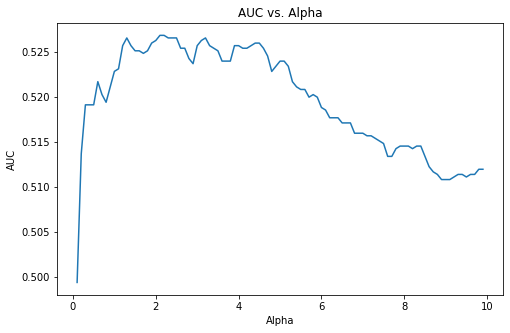

In [ ]:
_range = np.arange(0.1, 10, 0.1)
res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in _range], index=_range)

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
preds = probs[:, 1]
y_pred = np.where(preds >= 0.5, 1, 0)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 33.71%


# BERT
https://skimai.com/fine-tuning-bert-for-sentiment-analysis/


https://nbviewer.org/github/omontasama/nlp-huggingface/blob/main/fine_tuning/huggingface_fine_tuning.ipynb


LEGGERE: https://arxiv.org/pdf/1905.05583.pdf 

### Prepare data for training

In [ ]:
def clean_tweet_lite(text):
  
  # lowercase
  text = text.lower()

  # remove links
  regex = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
  text = re.sub(regex, '', text)

  # replace users mentions
  text = ' '.join(re.sub("(@[A-Za-z0-9_]+)", "@user", text).split())

  # fix punctuation
  text = text.replace(' . ', '. ').replace(' , ', ', ').replace(' : ', ': ').replace(' ; ', '; ').replace(' ? ', '? ').replace(' ! ', '! ')

  # fix whitespaces
  text = ' '.join(text.split())

  text = text.replace('&lt;', '<').replace('&gt;', '>').replace('&amp;', '&').replace('&#39;', '\'').replace('&#039;', '\'')

  return text


# def clean_tweet_lite(text):
  
#   # lowercase
#   text = text.lower()

#   # remove links
#   regex = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
#   text = re.sub(regex, '', text).strip()

#   # replace html chars
#   text = BeautifulSoup(text).get_text()
#   text = text.replace('\x92', '\'') # quotes
#   text = text.replace('[', '(').replace(']', ')') # brackets

#   # replace errors on accents and contractions
#   text = text.replace('e\'', 'è').replace('a\'', 'à').replace('i\'', 'ì').replace('o\'', 'ò').replace('u\'', 'ù')
#   text = text.replace(' c\'è ', ' ci è ').replace(' l\'', ' il ').replace(' d\'', ' di ').replace(' dell\'', ' dello ').replace(' dall\'', ' dallo ').replace(' sull\'', ' sullo ')

#   # remove mentions and hashtags
#   text = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9]+)", " ", text).split())

#   # if it doesn't contain letters
#   if not re.search('[a-zA-Z]', text):
#     return None

#   # remove non alpha numeric chars
#   text = ' '.join(re.sub(r'\W+', " ", text).split())

#   # fix start of tweet
#   text = text[text.find(next(filter(str.isalpha, text))):]

#   # repetitions
#   text = re.sub("(.)\\1{2,}", "\\1\\1", text)

#   # space after .,?
#   text = re.sub(r'(?<=[.,?])(?=[^\s])', r' ', text) + ' '

#   # # patterns with .,?
#   text = re.sub("(\. ){2,}", ". ", text)
#   text = re.sub("(, ){2,}", ", ", text)
#   text = re.sub("(\? ){2,}", "? ", text)
#   text = re.sub("(! ){2,}", "! ", text)

#   text = text.replace(' . ', '. ').replace(' , ', ', ').replace(' ? ', '? ').replace(' ! ', '! ')

#   text = text.strip()

#   # remove stopwords 
#   text = text.split()
#   common_stopwords = stopwords_list.intersection(set(text))
#   text = list(filter(lambda a: a not in common_stopwords, text))
#   text = ' '.join(text)

  
#   if len(text.split()) < 5:
#     return None

#   return text

In [ ]:
### clean tweets text
df = start_df.copy()
df['text'] = df['text'].apply(lambda x: clean_tweet_lite(x))
df = df.dropna().drop_duplicates()

In [ ]:
### split train e validation
X = list(df['text'])
y = list(df['sentiment'])
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True, stratify=y)

In [ ]:
### one-hot encoding
enc = OneHotEncoder()
y_train = enc.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = enc.transform(np.array(y_val).reshape(-1, 1)).toarray()

In [ ]:
### tokenize sentences
all_tweets = np.concatenate([X_train, X_val])
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]
max_len = max([len(sent) for sent in encoded_tweets])
if max_len < 100:
  max_len = 100
print('Max length: ', max_len)

ids_train, masks_train = bertTokenize(X_train, tokenizer, max_len)
ids_val, masks_val = bertTokenize(X_val, tokenizer, max_len)

Max length:  100


### Hyperparameters

In [ ]:
epochs = 50
batch_size = 32
loss = keras.losses.CategoricalCrossentropy()
output_function = 'softmax'

lr = 2e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

patience = 3
stop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

### Costruzione rete

In [ ]:
def create_model(bert_model):

  # inputs
  ids = layers.Input(shape=(max_len,), dtype='int32')
  masks = layers.Input(shape=(max_len,), dtype='int32')

  # # embedding
  # embed = bert_model([ids, masks]).last_hidden_state[:, 0, :]

  # # network
  # dense = layers.Dense(768, activation='relu')(embed)
  # dense = layers.Dropout(0.2)(dense)
  # dense = layers.Dense(768, activation='relu')(embed)
  # dense = layers.Dropout(0.2)(dense)
  # dense = layers.Dense(128, activation='relu')(dense)
  # dense = layers.Dropout(0.2)(dense)
  # dense = layers.Dense(n_classes, activation=output_function)(dense)
  # return models.Model(inputs=[ids, masks], outputs=dense)
  

  # embedding
  embed = bert_model([ids, masks])[0]

  # lstms
  lstm1 = layers.LSTM(512, return_sequences=False, dropout=0.2)(embed)

  # rest of network
  dense1 = layers.Dense(256)(lstm1)
  dropout1 = layers.Dropout(0.3)(dense1)
  relu1 = layers.ReLU()(dropout1)
  
  dense1 = layers.Dense(128)(relu1)
  dropout1 = layers.Dropout(0.3)(dense1)
  relu1 = layers.ReLU()(dropout1)

  dense1 = layers.Dense(n_classes, activation=output_function)(relu1)

  return models.Model(inputs=[ids, masks], outputs=dense1)



with strategy.scope():
  config = BertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  bert_model = TFBertModel.from_pretrained(model_name, config, from_pt=True)
  for layer in bert_model.layers:
      layer.trainable = False
  model = create_model(bert_model)
  model.compile(optimizer=optimizer, 
                loss=loss, 
                metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  184345344   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

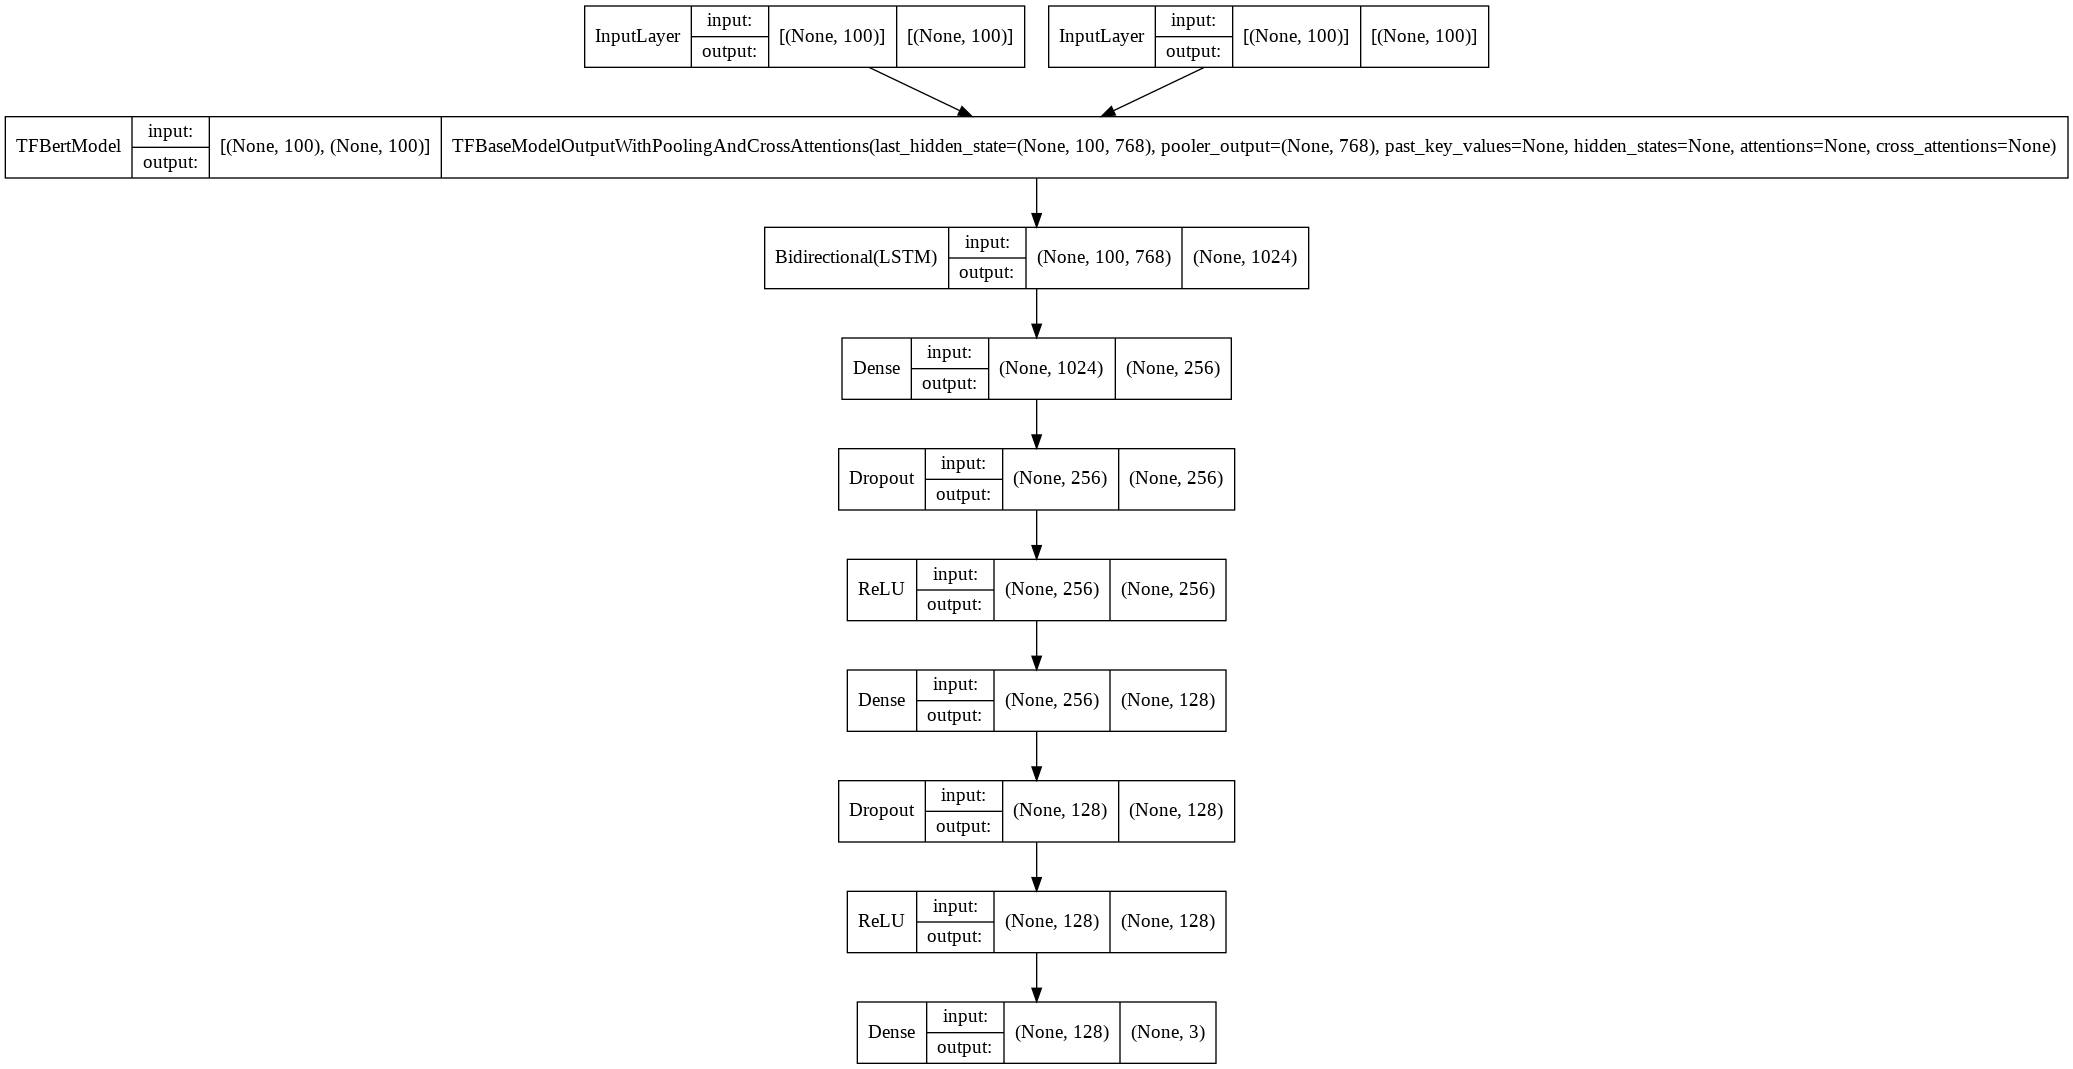

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=96)

### Training

In [ ]:
training_history = model.fit(
    [ids_train, masks_train], 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=([ids_val, masks_val], y_val), 
    callbacks=[stop_callback], 
) 

Epoch 1/50
110/110 [==============================] - 79s 392ms/step - loss: 1.0335 - accuracy: 0.4637 - val_loss: 0.9299 - val_accuracy: 0.5672
Epoch 2/50
110/110 [==============================] - 11s 99ms/step - loss: 0.8867 - accuracy: 0.5930 - val_loss: 0.8647 - val_accuracy: 0.6002
Epoch 3/50
110/110 [==============================] - 11s 100ms/step - loss: 0.8275 - accuracy: 0.6326 - val_loss: 0.8513 - val_accuracy: 0.6116
Epoch 4/50
110/110 [==============================] - 11s 99ms/step - loss: 0.7946 - accuracy: 0.6477 - val_loss: 0.8492 - val_accuracy: 0.6253
Epoch 5/50
110/110 [==============================] - 11s 100ms/step - loss: 0.7572 - accuracy: 0.6722 - val_loss: 0.8482 - val_accuracy: 0.6241
Epoch 6/50
110/110 [==============================] - 11s 99ms/step - loss: 0.7325 - accuracy: 0.6719 - val_loss: 0.8330 - val_accuracy: 0.6241
Epoch 7/50
110/110 [==============================] - 9s 80ms/step - loss: 0.6960 - accuracy: 0.7140 - val_loss: 0.8389 - val_accurac

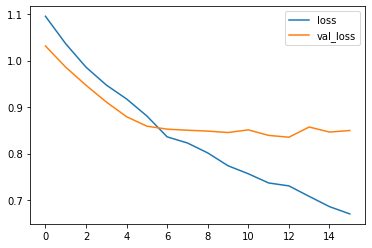

In [ ]:
for c in ['loss', 'val_loss']:
  plt.plot(training_history.history[c], label=c)
plt.legend()
plt.show();

In [ ]:
# model.save_weights(base_path+"weights_ultimi.h5", overwrite=True)

In [ ]:
# model.load_weights(base_path+"weights_ultimi.h5")

### Validation results

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def classify(arr, threshold):
  if (np.argmax(arr) == 0) and (arr[0] >= threshold): #negative
    return 0
  elif (np.argmax(arr) == 2) and (arr[2] >= threshold): #positive
    return 2
  else:
    return 1

In [ ]:
tmp = model.predict([ids_val, masks_val])
y_pred = enc.transform(np.array(np.argmax(tmp, axis=1)).reshape(-1, 1)).toarray()

print(accuracy_score(y_val, y_pred))
print()
print(classification_report(y_val, y_pred))

0.6480637813211845

              precision    recall  f1-score   support

           0       0.62      0.74      0.68       293
           1       0.63      0.50      0.55       292
           2       0.69      0.71      0.70       293

   micro avg       0.65      0.65      0.65       878
   macro avg       0.65      0.65      0.64       878
weighted avg       0.65      0.65      0.64       878
 samples avg       0.65      0.65      0.65       878



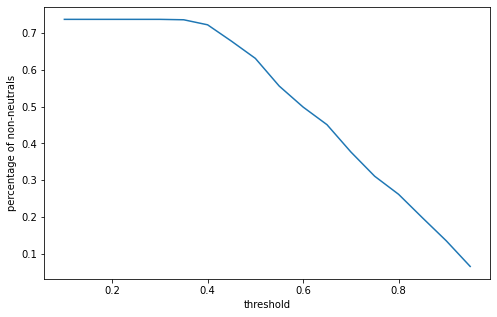

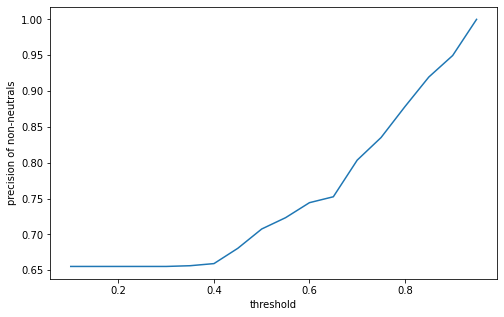

In [ ]:
x = list(np.arange(0.1, 1, 0.05))
rows = []

for t in x:
  tmp2 = [classify(tw, t) for tw in tmp]

  # percentage of non-neutrals
  count = pd.value_counts(tmp2).to_dict()
  if 0 not in count:
    count[0] = 0
  if 2 not in count:
    count[2] = 0
  perc = (count[0]+count[2])/(np.sum(list(count.values())))

  # precision of non-neutrals
  y_true = enc.inverse_transform(y_val).reshape(-1)
  result = list(zip(tmp2, y_true))
  result = [r for r in result if r[0] != 1]
  y_pred = [r[0] for r in result]
  y_true = [r[1] for r in result]
  acc = accuracy_score(y_true, y_pred)
  
  rows.append((perc,acc))

tmp_df = pd.DataFrame(rows, index=x, columns=['percentage', 'precision'])


plt.rcParams["figure.figsize"] = (8,5)
for c in tmp_df.columns: 
  plt.plot(tmp_df[c])
  plt.xlabel('threshold')
  plt.ylabel(c+' of non-neutrals')
  plt.show();

In [ ]:
texts = np.array([
                 "io vi ammazzo tutti merde morte sangue violenza", 
                 "oggi è proprio una bella giornata splendente, viva la vita", 
                 "#Milano è tornato il #SaloneDelMobile, dopo uno stop di 18 mesi dovuto alle restrizioni legate alla pandemia. All'inaugurazione ha partecipato anche il Presidente Mattarella. #supersalone21 https://t.co/kthM9Y9YzZ", 
                #  "banana", 
                 'Fuorisalone 2019: gli eventi di moda e gli appuntamenti da non perdere a Milano https://t.co/PqbseSK69w', 
                 '@SkyTG24: Milano, al via la 57esima edizione del Salone del Mobile https://t.co/e0mf6k5Z3B',
                 "Porta Venezia in Design 2019: un percorso che unisce design e food&amp;wine: Tutti gli eventi 2019 del circuito Porta Venezia in Design che unisce il design al food&amp;wine con un focus particolare sullo stile Liberty che caratterizza l'intera zona di Porta… https://t.co/ohKwpKdxj6 https://t.co/Zz20CyYaIM",
                 "@terminologia: #itanglese al #fuorisalone:\rcorte del food, food court, truckerS del cucù truck, eV-now… 🙄 \rMa #parlacomemangi (cibo!) e…", 
                 "Venerdi 12 Aprile 2019\nIn occasione del Salone del Mobile\n\nLISTA TRIO ha l'onore di invitarti presso l' Urban Garden del NYX Hotel Milan\n\nNuovissimo Hotel Lifestyle nel vivace centro di Milano !\n-\nCHILLOUT DELUXE... https://t.co/JoBzS7527D",
                 'Sincronizzate le agende e non perdetevi neanche un appuntamento di questo Salone del Mobile https://t.co/BJDRfwbkmz https://t.co/qG4kG2fQOY',
                 ])
texts = np.array([clean_tweet_lite(t) for t in texts])
print(texts)
print()

ids_tmp, masks_tmp = bertTokenize(texts, tokenizer, max_len)
tmp_pred = model.predict([ids_tmp, masks_tmp])

print(tmp_pred)
print()

print([classify(p, 0.7) for p in tmp_pred])

['io vi ammazzo tutti merde morte sangue violenza'
 'oggi è proprio una bella giornata splendente, viva la vita'
 "#milano è tornato il #salonedelmobile, dopo uno stop di 18 mesi dovuto alle restrizioni legate alla pandemia. all'inaugurazione ha partecipato anche il presidente mattarella. #supersalone21"
 'fuorisalone 2019: gli eventi di moda e gli appuntamenti da non perdere a milano'
 '@user: milano, al via la 57esima edizione del salone del mobile'
 "porta venezia in design 2019: un percorso che unisce design e food&wine: tutti gli eventi 2019 del circuito porta venezia in design che unisce il design al food&wine con un focus particolare sullo stile liberty che caratterizza l'intera zona di porta…"
 '@user: #itanglese al #fuorisalone: corte del food, food court, truckers del cucù truck, ev-now… 🙄 ma #parlacomemangi (cibo!) e…'
 "venerdi 12 aprile 2019 in occasione del salone del mobile lista trio ha l'onore di invitarti presso l' urban garden del nyx hotel milan nuovissimo hotel lif

### Test sentpolc ita

In [ ]:
test = pd.read_csv(base_path+'files/test_set_sentipolc16_gold2000.csv', escapechar='\\', header=None)
test.columns = ["idtwitter","subj","opos","oneg","iro","lpos","lneg", "top", "text"]
test['sentiment'] = test.apply(lambda x: 
                               0 if (x['lneg'] == 1 and x['lpos']==0) else 
                               2 if (x['lneg'] == 0 and x['lpos']==1) else 
                               1, axis=1)
test = test.dropna()

texts = np.array(test['text'])
texts = np.array([clean_tweet_lite(t) for t in texts])
texts = [x if x is not None else '' for x in texts]

y_test = np.array(test['sentiment'])

ids_tmp, masks_tmp = bertTokenize(texts, tokenizer, max_len)
ids_tmp = np.asarray(ids_tmp).astype('float32')
masks_tmp = np.asarray(masks_tmp).astype('float32')

In [ ]:
tmp_pred = model.predict([ids_tmp, masks_tmp])

In [ ]:
y_pred = np.argmax(tmp_pred, axis=1)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.591
              precision    recall  f1-score   support

           0       0.57      0.33      0.41       577
           1       0.62      0.78      0.69      1054
           2       0.51      0.48      0.49       369

    accuracy                           0.59      2000
   macro avg       0.56      0.53      0.53      2000
weighted avg       0.58      0.59      0.57      2000



### Classify dataset

In [ ]:
! mkdir files
! cp "drive/MyDrive/Università/5/Stage/tweets-analysis/TweetsSentiment.py" .
! cp "drive/MyDrive/Università/5/Stage/tweets-analysis/TweetsUtils.py" .

mkdir: cannot create directory ‘files’: File exists


In [ ]:
from TweetsUtils import *
from datetime import datetime, timedelta

In [ ]:
def read_tweets(years):
    tweets, users, places = [], [], []
    for year in years:
        tmp_tweets, tmp_users, tmp_places = read_tweets_files(year)
        tweets += tmp_tweets
        users += tmp_users
        places += tmp_places
    return tweets, users, places



def read_tweets_files(year):
    tmp_path = base_path + 'tweets/mdw' + str(year)[-2:] + '_tweets/'
    tweets_filename = tmp_path + 'mdw' + str(year)[-2:] + '_tweets_contents.json'
    users_filename = tmp_path + 'mdw' + str(year)[-2:] + '_tweets_users.json'
    places_filename = tmp_path + 'mdw' + str(year)[-2:] + '_tweets_places.json'
    
    tmp_tweets = read_file(tweets_filename)
    tmp_users = read_file(users_filename)
    tmp_places = read_file(places_filename)

    for tw in tmp_tweets:
        tw['datetime'] = datetime.strptime(tw['datetime'], '%Y-%m-%d %H:%M:%S')
    
    # tmp_tweets = center_week(tmp_tweets, year)
    
    return tmp_tweets, tmp_users, tmp_places

In [ ]:
tweets, users, places = read_tweets(years)

print('TOT:', len(tweets), 'tweets')
print('TOT:', len(users), 'users')
print('TOT:', len(places), 'places')

TOT: 71061 tweets
TOT: 30182 users
TOT: 286 places


In [ ]:
unique_texts = select_fields(tweets, ['text'], as_list=True, unique=True)
print(len(unique_texts))

# texts = list(set([clean_tweet_lite(t) for t in unique_texts]))
# texts = [x if x is not None else '' for x in texts]

texts = [x[:max_len] for x in unique_texts] # capire cosa fa dare errore con testi nemmeno così tanto lunghi

tokenizer = AutoTokenizer.from_pretrained(model_name)
ids_tmp, masks_tmp = bertTokenize(texts, tokenizer, max_len)

45435


In [ ]:
pred = model.predict([ids_tmp, masks_tmp])

In [ ]:
d = {unique_texts[i]: classify(pred[i], threshold=0.9) for i in range(len(pred))}
pd.value_counts(list(d.values()))

1    45211
0      156
2       68
dtype: int64

In [ ]:
sent = 0
tmp = pd.DataFrame()
tmp['text'] = list(d.keys())
tmp['sentiment'] = list(d.values())
list(tmp[tmp['sentiment']==sent].sample(10)['text'])

["Ah cioè noi il carnaio del salone del mobile lo accogliamo con una rossa senz'aria condizionata? Cosa siamo, Roma?",
 'Salone del Mobile, orde di Nomadi incinte assaltano visitatori: borseggiano a gruppi di 40 https://t.co/72wFzkKgsD',
 'agli infami di lignano sabbiadoro che per la notte del concerto di jovanotti stanno mettendo le camere a mille e passa euro: furboni, non siamo qatarioti e quello non è il salone del mobile. dormiamo volentieri a portogruaro, deficienti paesani di merda',
 'Immaginate quelli in giro per il Fuorisalone con #InstagramDown, il PANICOOO.',
 'Raga io comunque non ho mai capito che è sto salone del mobile',
 'Borseggiano da anni. Restano impunite, raccontando sempre di essere incinte. In questi giorni di metro piena fanno straordinari.\nLa security non puó far molto perché altrimenti quelli di sinistra urlano al fascismo, oppure incolpano gli alpini.\n#salonedelmobile https://t.co/rKvys2xpSC',
 'Quell\'opera «brutta e ingombrante» serve a far pensare piutt

In [ ]:
# MOSTRARE PAROLE PIU' USATE, ENTITA'...
a = list(tmp[tmp['sentiment']==sent]['text'])
a = [clean_tweet_lite(t) for t in a]
a = ' '.join(np.array(a).reshape(-1)).split()
pd.value_counts(a).head(50)

di                  112
che                  97
salone               82
del                  81
e                    78
il                   78
a                    62
non                  53
in                   43
al                   41
la                   40
fuori                38
ma                   36
per                  36
mobile               34
fuorisalone          31
è                    29
@user                24
un                   23
i                    21
si                   21
mi                   20
sono                 20
da                   18
quelli               18
le                   18
con                  17
ci                   16
come                 16
una                  15
andare               15
cazzo                15
io                   15
sto                  14
ha                   12
odiano               12
vi                   12
incinte              10
mobile,              10
se                   10
lo                   10
gente           

In [ ]:
# for tw in tweets:
#   tw['sentiment'] = d[tw['text']]
#   tw['preprocessed_text'] = clean_tweet_full(tw['text'])

In [ ]:
# save_file(tweets, base_path+'tweets/total_tweets.json')

# BERT method 2
Fine-tuning huggingface (non otimizzato per tpu, mezz'ora ad epoca)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
val_data = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=n_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
loss = 'categorical_crossentropy'

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/546M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 3
batch_size = 64
# patience = 3

# stop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

net_hist = model.fit(train_data.batch(batch_size), 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     validation_data=val_data.batch(batch_size), 
                    #  callbacks=[stop_callback], 
                     )

Epoch 1/3
48/48 [==============================] - 151s 3s/step - loss: 6.0318 - accuracy: 0.3096 - val_loss: 5.2329 - val_accuracy: 0.3280
Epoch 2/3
48/48 [==============================] - 126s 3s/step - loss: 5.6237 - accuracy: 0.3116 - val_loss: 4.7363 - val_accuracy: 0.3267
Epoch 3/3
48/48 [==============================] - 127s 3s/step - loss: 5.4926 - accuracy: 0.3106 - val_loss: 4.3852 - val_accuracy: 0.3280
